# Notebook to check what is going on with the data during training

In [1]:
import cv2
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
import open3d as o3d
from numpy.typing import NDArray

sys.path.insert(0, '../source')
from wet_test import DLIB_2_FACE_BLAZE_MAPPING


# set NumPy print precision for better readability
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# load x data dumped during run of test.py
x_0_0 = torch.load('../x_epoch_0_iter_0.pt')
print(x_0_0.shape)

x_0_1 = torch.load('../x_epoch_0_iter_1.pt')
x_0_2 = torch.load('../x_epoch_0_iter_2.pt')
x_0_3 = torch.load('../x_epoch_0_iter_3.pt')
x_0_4 = torch.load('../x_epoch_0_iter_4.pt')


torch.Size([100, 2, 68])


## Analyze data for a few data points in a single batch

It seems that from data frame to data frame in a single batch face location & distance does not change much to simulate face motion in a given direction.
The focal length for a given batch is constant.

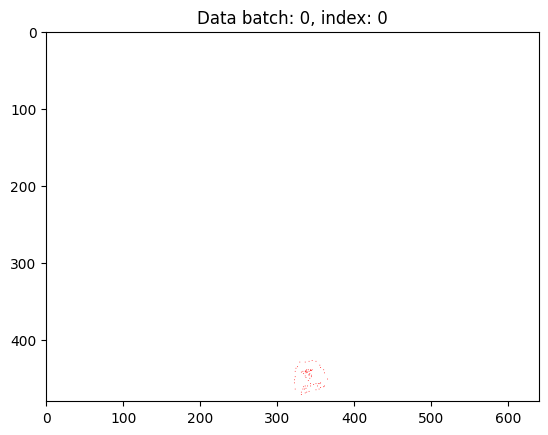

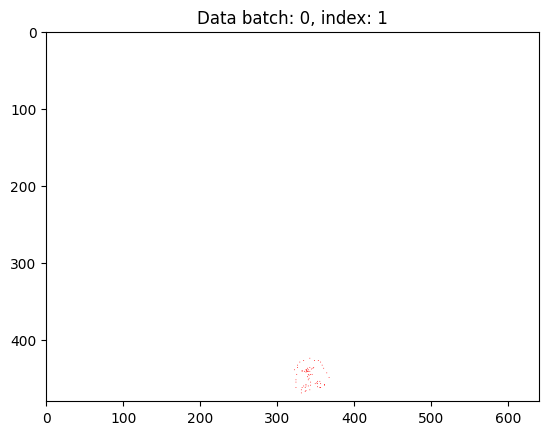

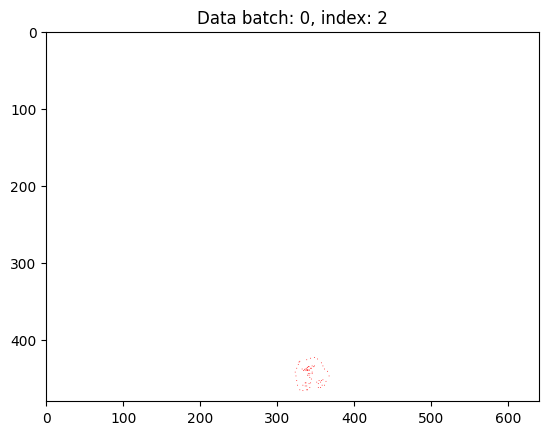

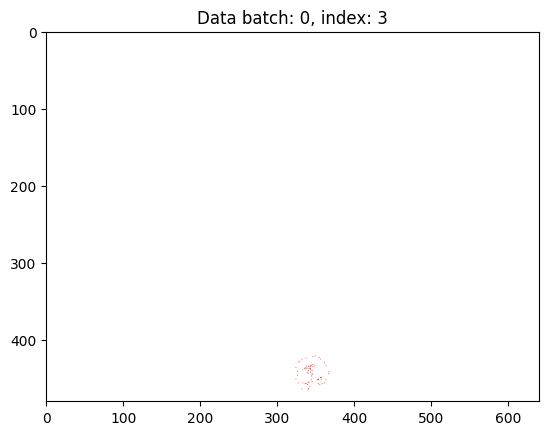

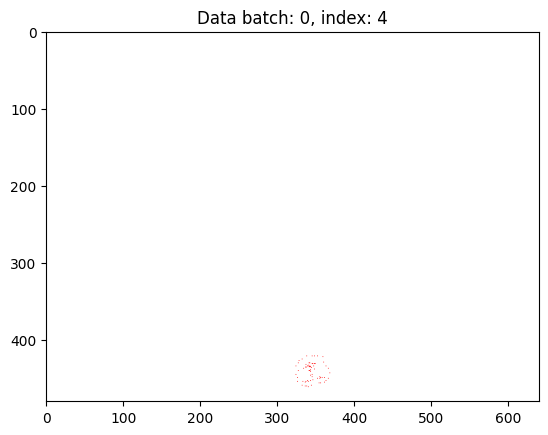

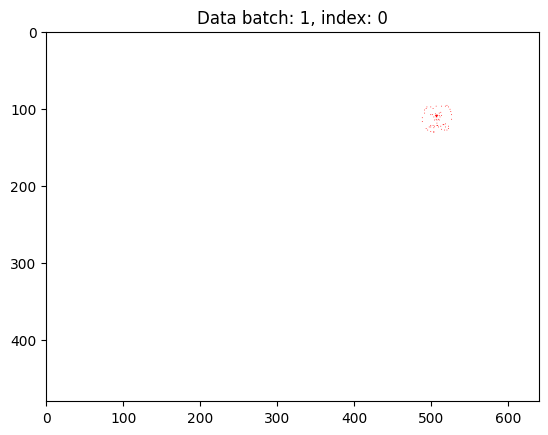

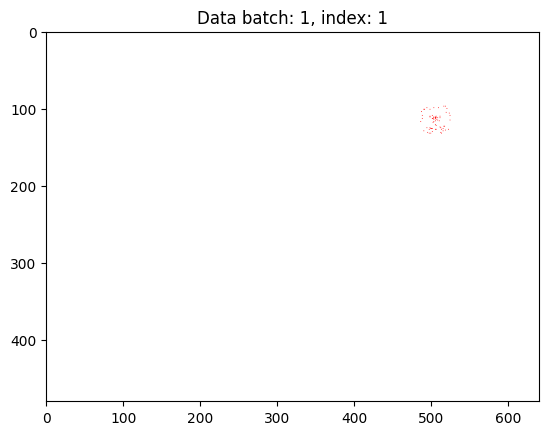

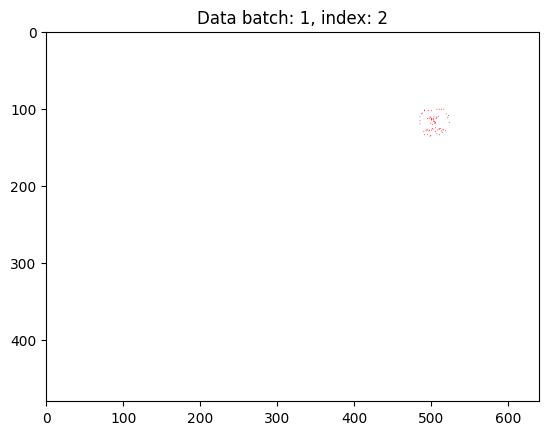

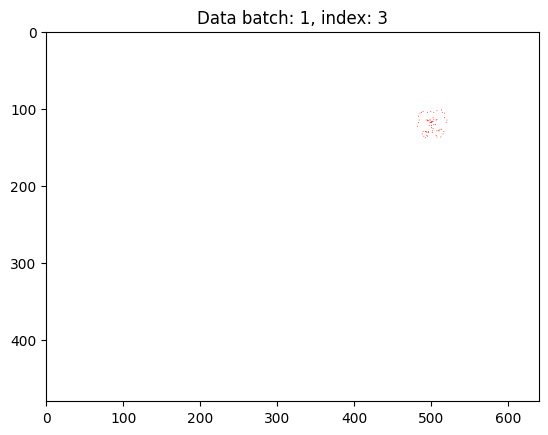

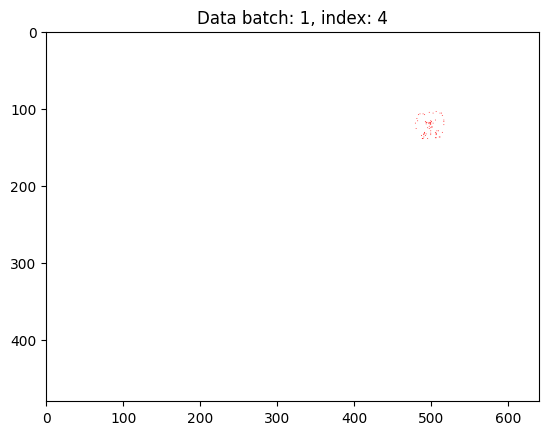

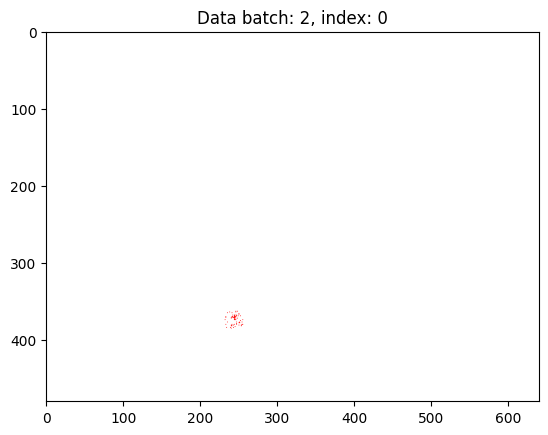

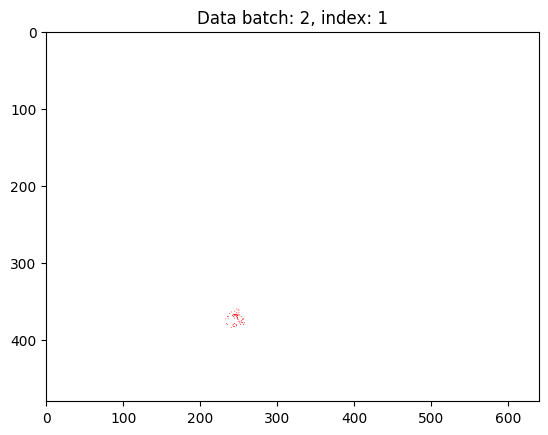

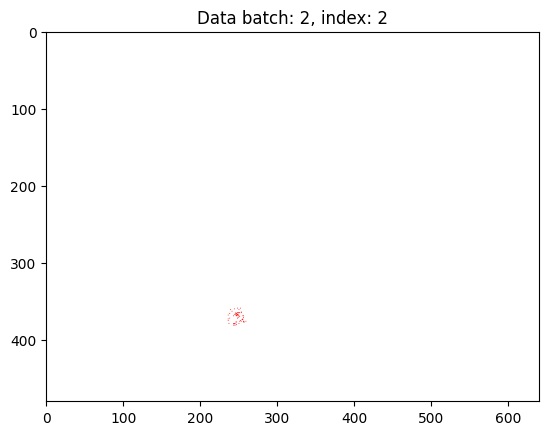

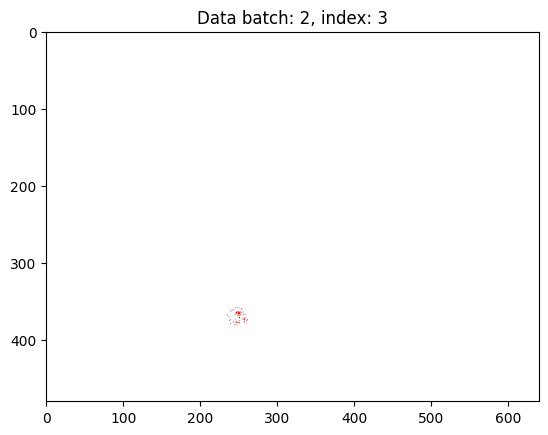

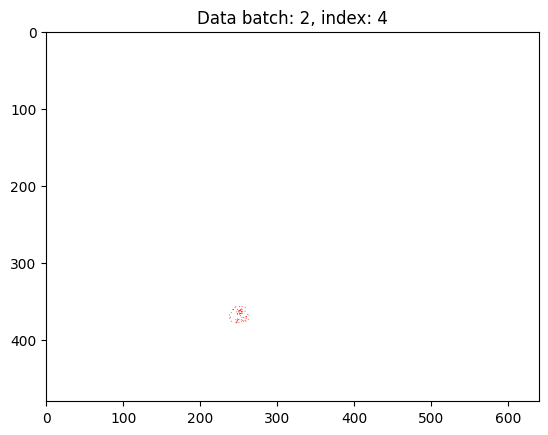

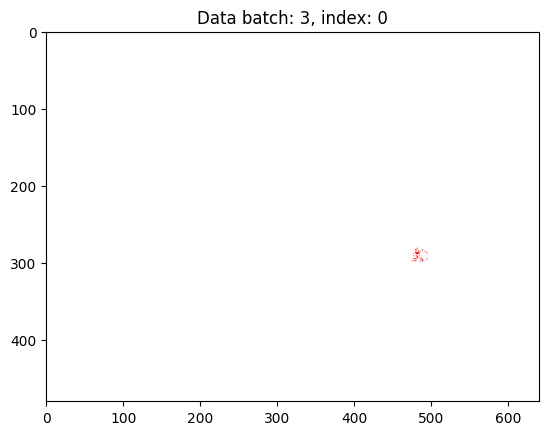

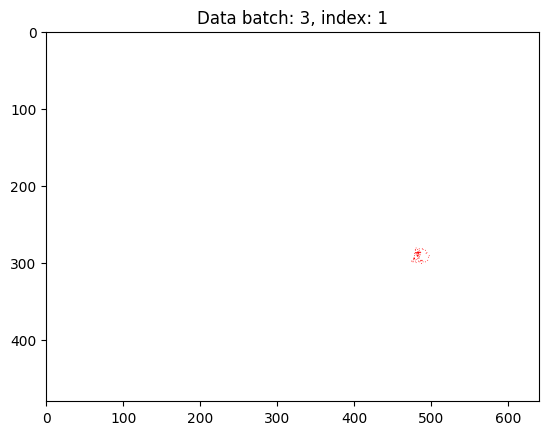

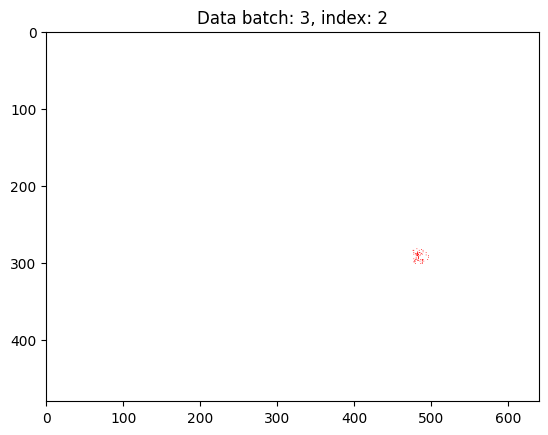

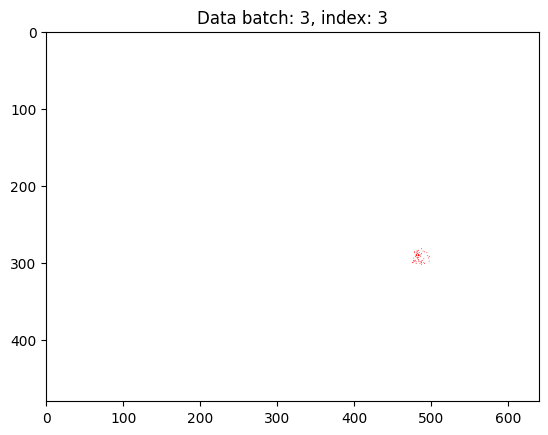

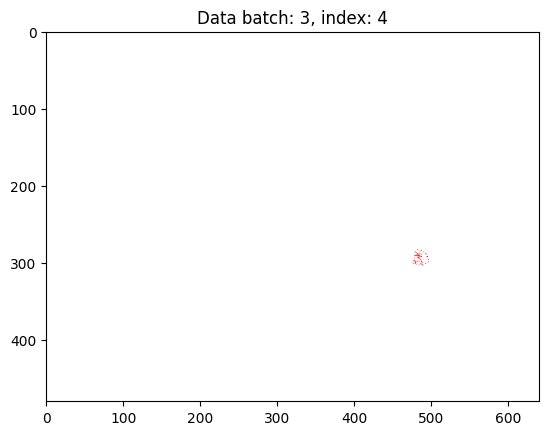

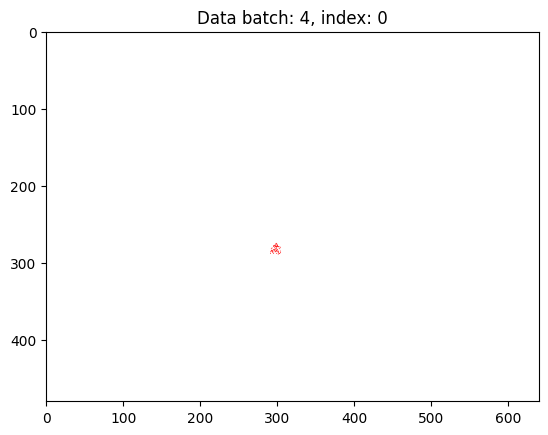

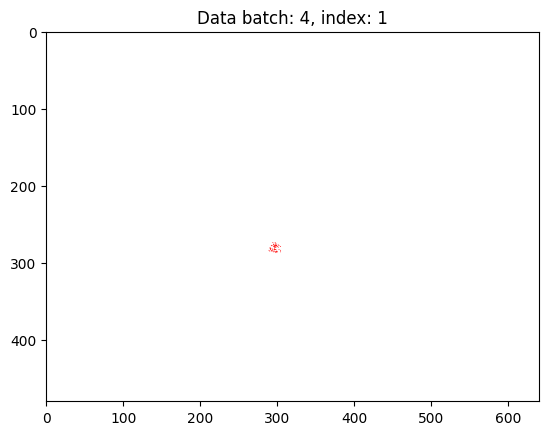

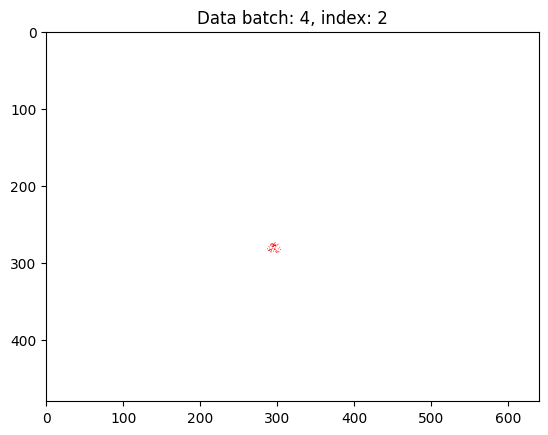

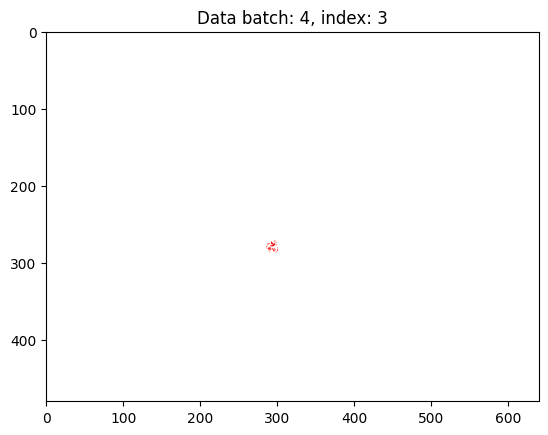

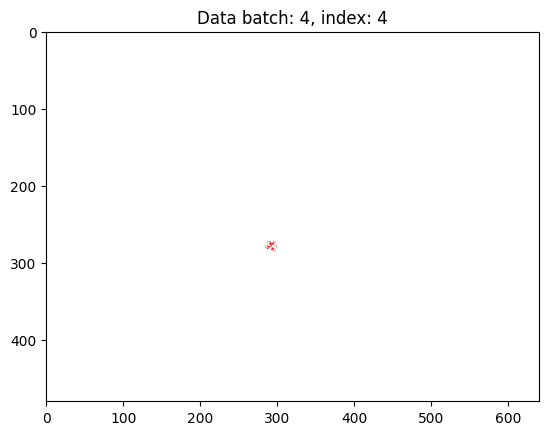

In [3]:
for i, x_data in enumerate([x_0_0, x_0_1, x_0_2, x_0_3, x_0_4]):
    assert x_data.shape == (100, 2, 68)

    # display first 5 frames from a given train batch
    for j in range(5):
        img = np.ones((480, 640, 3), dtype=np.uint8) * 255

        # extract a single set of keypoints projections
        keypoints = x_data[j, :, :]

        for k in range(keypoints.shape[1]):
            keypoint = keypoints[:, k]
            keypoint = keypoint.numpy().astype(np.int32)
            img[keypoint[1], keypoint[0]] = [255, 0, 0]

        plt.title(f'Data batch: {i}, index: {j}')
        plt.imshow(img)
        plt.show()

## Visualize landmark indexes

This data seems very noisy after inspection.

These landmarks correspond to dlib's 68 landmarks, but for some reason the coordinate system is mirrored (vs, one used on OpenCV) around vertical axis and horizontal axis.

(2, 68)
330
406
374
451
44 45


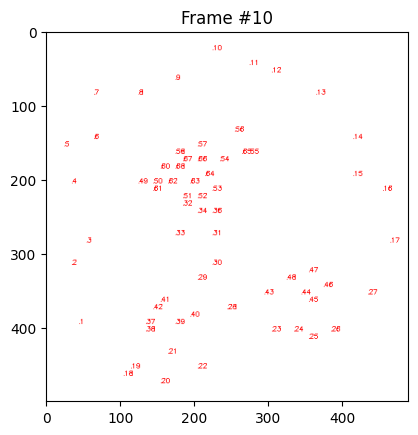

In [6]:
FRAME_INDEX = 10

# convert landmarks locations from tensor to NumPy array
landmarks = x_0_0[FRAME_INDEX, :, :].numpy().astype(np.int32)

# get the value range for landmarks
print(landmarks.shape)
min_x, min_y = np.min(landmarks, axis=1)
print(min_x)
print(min_y)
max_x, max_y = np.max(landmarks, axis=1)
print(max_x)
print(max_y)

# define the image as a crop of original image frame based on min & max location of landmarks for better visualization
width = max_x - min_x
height = max_y - min_y
print(width, height)

RESOLUTION_RATIO = 10.0

# set the entire image to white color
width = width * 10 + 50
height = height * 10 + 50
img = np.ones((height, width, 3), dtype=np.uint8) * 255

for i in range(landmarks.shape[1]):
    pixel = landmarks[:, i]
    # draw landmark
    # landmark_x = width - ((pixel[0] - min_x) * 10 + 25)
    # landmark_y = height - ((pixel[1] - min_y) * 10 + 25)
    landmark_x = ((pixel[0] - min_x) * 10 + 25)
    landmark_y = ((pixel[1] - min_y) * 10 + 25)
    img[landmark_y, landmark_x] = [255, 0, 0]
    # draw landmark index
    img = cv2.putText(img, f'{i+1}', (landmark_x, landmark_y), cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.3, color=(255, 0, 0))

plt.imshow(img)
plt.title(f'Frame #{FRAME_INDEX}')
plt.show()

## Experiment with projection of Faced Blaze face mesh points (DLib subset) onto artificial camera frame

In [7]:
# we try to simulate phone user-facing camera parameters
CAMERA_FRAME_WIDTH_PIXELS = 480.0
CAMERA_FRAME_HEIGHT_PIXELS = 640.0

DUMMY_CAMERA_MATRIX = np.array([
    [500.0, 0.0, CAMERA_FRAME_WIDTH_PIXELS / 2],
    [0.0, 500.0, CAMERA_FRAME_HEIGHT_PIXELS / 2],
    [0.0, 0.0, 1.0]
])

assert DUMMY_CAMERA_MATRIX.shape == (3, 3)
print(DUMMY_CAMERA_MATRIX)

[[500.000 0.000 240.000]
 [0.000 500.000 320.000]
 [0.000 0.000 1.000]]


In [8]:
# define all 3D Face Blaze landmarks in Face Coordinate System (FCS)

FACE_BLAZE_3D_LANDMARKS_FCS: np.ndarray = np.array([
    [0.0, 0.02279539, 0.01496097],
    [0.0, 0.0, 0.0],
    [0.0, 0.00962159, 0.01417337],
    [-0.00463928, -0.02082222, 0.00842021],
    [0.0, -0.00663695, -0.00110976],
    [0.0, -0.01492534, 0.00232734],
    [0.0, -0.0360012, 0.01686977],
    [-0.04253081, -0.03704511, 0.04195902],
    [0.0, -0.05145907, 0.0219084],
    [0.0, -0.06012844, 0.02090346],
    [0.0, -0.09388643, 0.02994069],
    [0.0, 0.02579946, 0.0161068],
    [0.0, 0.02791436, 0.01906174],
    [0.0, 0.02867571, 0.02256122],
    [0.0, 0.03415535, 0.0207085],
    [0.0, 0.03618712, 0.01946147],
    [0.0, 0.03892702, 0.01874156],
    [0.0, 0.04238258, 0.01940163],
    [0.0, 0.05022759, 0.02404232],
    [0.0, 0.0037423, 0.00363408],
    [-0.00416106, 0.00339584, 0.01027947],
    [-0.0708796, -0.06561666, 0.07375984],
    [-0.02628639, -0.03162763, 0.03627483],
    [-0.03198363, -0.0311268, 0.03678652],
    [-0.03775151, -0.03166267, 0.0382941],
    [-0.04465819, -0.03549815, 0.04320436],
    [-0.02164289, -0.03316732, 0.03623782],
    [-0.03208229, -0.04350791, 0.03359782],
    [-0.02673803, -0.04332202, 0.03383401],
    [-0.03745193, -0.04292151, 0.03503195],
    [-0.04161018, -0.04185934, 0.0375605],
    [-0.05062006, -0.03061283, 0.04699511],
    [-0.02266659, 0.06298903, 0.03085792],
    [-0.04445859, -0.03790856, 0.04302182],
    [-0.0721453, -0.03389874, 0.07402454],
    [-0.05799793, -0.03476411, 0.05271545],
    [-0.02844939, -0.00405997, 0.03042474],
    [-0.00711452, 0.0220249, 0.0159856],
    [-0.00606033, 0.02797697, 0.02030681],
    [-0.01431615, 0.02374088, 0.01979415],
    [-0.0191491, 0.02676281, 0.02446674],
    [-0.01131043, 0.02847072, 0.02285956],
    [-0.01563548, 0.02955898, 0.02633341],
    [-0.02650112, 0.03876784, 0.03287121],
    [-0.00427049, -0.00032731, 0.00115075],
    [-0.00496396, -0.00651206, 0.00035246],
    [-0.05253307, -0.05008447, 0.04112445],
    [-0.01718698, -0.02101474, 0.02917245],
    [-0.01608635, -0.00184349, 0.01661411],
    [-0.01651267, -0.00515997, 0.01894285],
    [-0.04765501, -0.00425311, 0.03940972],
    [-0.00478306, -0.01422631, 0.00374591],
    [-0.03734964, -0.05635095, 0.0292515],
    [-0.04588603, -0.05428902, 0.0342712],
    [-0.06279331, -0.07742292, 0.06049754],
    [-0.01220941, -0.0526903, 0.02369569],
    [-0.02193489, -0.04227182, 0.03475029],
    [-0.03102642, 0.03226119, 0.03379699],
    [-0.06719682, 0.0366178, 0.09221005],
    [-0.01193824, 0.0017993, 0.01737857],
    [-0.00729766, 0.00466847, 0.01642396],
    [-0.02456206, 0.03215756, 0.0319172],
    [-0.02204823, 0.03177643, 0.03313105],
    [-0.04985894, -0.05929326, 0.03723627],
    [-0.01592294, 0.00130844, 0.02018655],
    [-0.02644548, -0.05651519, 0.02554045],
    [-0.02760292, -0.06227836, 0.02459614],
    [-0.03523964, -0.09132841, 0.03746441],
    [-0.05599763, -0.06842335, 0.04751345],
    [-0.03063932, -0.07693009, 0.02945623],
    [-0.05720968, -0.05381449, 0.04644752],
    [-0.06374393, -0.05912455, 0.05883913],
    [-0.00672728, 0.02561151, 0.017378],
    [-0.0126256, 0.02660826, 0.02057825],
    [-0.01732553, 0.02825902, 0.02475025],
    [-0.01043625, 0.00338108, 0.01813149],
    [-0.02321234, 0.03202204, 0.03217448],
    [-0.02056846, 0.03350806, 0.02954721],
    [-0.02153084, 0.03149457, 0.03437511],
    [-0.00946874, -0.00091616, 0.0096333],
    [-0.01469132, 0.02909486, 0.02870696],
    [-0.0102434, 0.02862986, 0.02548911],
    [-0.00533422, 0.02866357, 0.02337402],
    [-0.0076972, 0.04968529, 0.02489721],
    [-0.00699606, 0.04164985, 0.020273],
    [-0.00669687, 0.03822905, 0.01965992],
    [-0.00630947, 0.03568236, 0.02026233],
    [-0.00583218, 0.03391117, 0.02135735],
    [-0.0153717, 0.03296341, 0.02730134],
    [-0.016156, 0.03349077, 0.02661972],
    [-0.01729053, 0.03491815, 0.02621141],
    [-0.01838624, 0.03701881, 0.02651867],
    [-0.0236825, 0.01979372, 0.02607508],
    [-0.07542244, -0.00077583, 0.09906925],
    [0.0, 0.00597138, 0.00874214],
    [-0.01826614, 0.03272666, 0.03076583],
    [-0.01929558, 0.03284966, 0.02978552],
    [-0.00597442, 0.00886821, 0.01609148],
    [-0.01405627, 0.00587331, 0.02234517],
    [-0.00662449, 0.00692456, 0.01611845],
    [-0.0234234, -0.01699087, 0.03181301],
    [-0.03327324, -0.01231728, 0.03361744],
    [-0.01726175, -0.002077, 0.02202249],
    [-0.05133204, -0.08612467, 0.04815162],
    [-0.04538641, -0.07446772, 0.0379218],
    [-0.03986562, -0.06236352, 0.03009289],
    [-0.02169681, 0.04313568, 0.0301973],
    [-0.01395634, -0.06138828, 0.02159572],
    [-0.016195, -0.07726082, 0.02554498],
    [-0.01891399, -0.09363242, 0.03200607],
    [-0.04195832, -0.0336207, 0.04100505],
    [-0.05733342, -0.02538603, 0.05043878],
    [-0.01859887, -0.03482622, 0.03632423],
    [-0.04988612, -0.04201519, 0.04391746],
    [-0.01303263, -0.02543318, 0.02644513],
    [-0.01305757, -0.00454086, 0.01059645],
    [-0.0646517, -0.02063984, 0.05785731],
    [-0.05258659, -0.02072676, 0.04501292],
    [-0.04432338, -0.01848961, 0.03952989],
    [-0.03300681, -0.01988506, 0.0360282],
    [-0.02430178, -0.02258357, 0.03436569],
    [-0.01820731, -0.02594819, 0.0325148],
    [-0.00563221, -0.03434558, 0.01908815],
    [-0.06338145, -0.00597586, 0.05594429],
    [-0.05587698, -0.04334936, 0.04787765],
    [-0.00242624, 0.00335992, 0.00404113],
    [-0.01611251, -0.01466191, 0.02580183],
    [-0.07743095, -0.03491864, 0.09480771],
    [-0.01391142, -0.02977913, 0.03026605],
    [-0.01785794, -0.00148581, 0.02625134],
    [-0.04670959, -0.03791326, 0.04391529],
    [-0.0133397, -0.00843104, 0.01378557],
    [-0.07270895, 0.01764052, 0.09728059],
    [-0.01856432, -0.0371211, 0.037177],
    [-0.00923388, -0.01199941, 0.0080366],
    [-0.05000589, 0.05008263, 0.05583081],
    [-0.05085276, 0.06051725, 0.06760893],
    [-0.07159291, -0.00315045, 0.07547648],
    [-0.05843051, 0.04121158, 0.06551513],
    [-0.06847258, -0.04789781, 0.06750909],
    [-0.02412942, 0.07131988, 0.03356391],
    [-0.00179909, 0.00562999, 0.00902303],
    [-0.02103655, -0.00962919, 0.02909485],
    [-0.06407571, -0.03362886, 0.05914761],
    [-0.03670075, -0.03487018, 0.03840374],
    [-0.03177186, -0.0342113, 0.036999],
    [-0.02196121, 0.03471457, 0.02995818],
    [-0.06234883, 0.00817565, 0.05812062],
    [-0.01292924, 0.08169055, 0.03381541],
    [-0.03210651, 0.07406413, 0.04673603],
    [-0.04068926, 0.06866244, 0.05550485],
    [0.0, -0.07672255, 0.02448293],
    [0.0, 0.08276513, 0.03211112],
    [-0.02724032, -0.03442667, 0.03698453],
    [-0.0228846, -0.03525756, 0.03778001],
    [-0.01998311, -0.03623412, 0.03786456],
    [-0.0613004, -0.04526126, 0.05437088],
    [-0.0228846, -0.04013369, 0.03700573],
    [-0.02724032, -0.04088675, 0.03603837],
    [-0.03177186, -0.04091001, 0.03598631],
    [-0.03670075, -0.04054579, 0.03751279],
    [-0.04018389, -0.03984222, 0.03992621],
    [-0.07555811, -0.05233676, 0.08467521],
    [-0.04018389, -0.0361056, 0.04034706],
    [0.0, 0.0139508, 0.01543339],
    [-0.01776217, 0.01557081, 0.02262488],
    [-0.01222237, 0.00055579, 0.01523139],
    [-0.00731493, 0.01409818, 0.01660261],
    [0.0, -0.04397892, 0.02239589],
    [-0.04135272, 0.05869773, 0.04803634],
    [-0.03311811, 0.0653395, 0.04092641],
    [-0.01313701, 0.0751313, 0.02773148],
    [-0.05940524, 0.05096764, 0.08107072],
    [-0.01998311, -0.03870703, 0.03731574],
    [-0.00901447, -0.02363857, 0.01721348],
    [0.0, 0.07638378, 0.02584163],
    [-0.02308977, 0.07847331, 0.03866534],
    [-0.06954154, 0.01312978, 0.07606767],
    [-0.01098819, 0.03331923, 0.02354877],
    [-0.01181124, 0.03453131, 0.0228604],
    [-0.01255818, 0.03661036, 0.02238553],
    [-0.01325085, 0.03979642, 0.02270594],
    [-0.01546388, 0.04692527, 0.02717711],
    [-0.01953754, 0.03057027, 0.03043891],
    [-0.02117802, 0.03010228, 0.02920508],
    [-0.02285339, 0.02924331, 0.02893166],
    [-0.0285016, 0.02538855, 0.0299061],
    [-0.05278538, 0.01112077, 0.0461438],
    [-0.00946709, -0.03034493, 0.02278825],
    [-0.01314173, -0.04231777, 0.032442],
    [-0.0178, -0.03986865, 0.03594049],
    [-0.0184511, 0.02972015, 0.0322834],
    [-0.05436187, 0.02903617, 0.05365752],
    [-0.00766444, -0.04308996, 0.02614151],
    [-0.01938616, 0.05487545, 0.02954519],
    [0.0, -0.02186278, 0.00700999],
    [-0.00516573, -0.02710437, 0.01327241],
    [0.0, -0.02855234, 0.01158854],
    [-0.01246815, -0.01357162, 0.01794568],
    [0.0, 0.06815329, 0.02294431],
    [0.0, 0.05864634, 0.02322126],
    [-0.00997827, 0.05804056, 0.02496028],
    [-0.03288807, 0.04255649, 0.03679852],
    [-0.02311631, 0.00439372, 0.02885519],
    [-0.0268025, 0.04984702, 0.03379452],
    [-0.03832928, 0.00410461, 0.03337873],
    [-0.0296186, 0.0114735, 0.03034661],
    [-0.04386901, 0.01556421, 0.03831718],
    [-0.01217295, 0.067076, 0.02506318],
    [-0.01542374, -0.00990022, 0.02274596],
    [-0.03878377, 0.04914899, 0.04164525],
    [-0.03084037, 0.05682977, 0.03661409],
    [-0.03747321, 0.0337668, 0.03749151],
    [-0.06094129, 0.02079126, 0.06002122],
    [-0.04588995, 0.03601861, 0.04492383],
    [-0.06583231, 0.02814404, 0.07405336],
    [-0.0349258, 0.02068955, 0.03345406],
    [-0.01255543, -0.01929206, 0.02168053],
    [-0.01126122, -0.00193263, 0.00936819],
    [-0.01443109, 0.00015909, 0.01570477],
    [-0.00923043, -0.00597823, 0.00472181],
    [-0.01755386, -0.04655982, 0.03147908],
    [-0.02632589, -0.04840693, 0.03110975],
    [-0.03388062, -0.04848841, 0.03166576],
    [-0.04075766, -0.04802278, 0.03399541],
    [-0.0462291, -0.04601556, 0.03829283],
    [-0.05171755, -0.03662618, 0.04804737],
    [-0.07297331, -0.01890037, 0.07524373],
    [-0.04706828, -0.02777865, 0.04366072],
    [-0.04071712, -0.02603686, 0.0399866],
    [-0.03269817, -0.02597524, 0.03743659],
    [-0.02527572, -0.02744176, 0.0361016],
    [-0.01970894, -0.0298537, 0.03513822],
    [-0.01579543, -0.03224806, 0.03390608],
    [-0.07664182, -0.01799997, 0.09911471],
    [-0.01397041, 0.00213274, 0.01845226],
    [-0.00884838, -0.01785605, 0.01242372],
    [-0.00767097, -0.0015883, 0.00397672],
    [-0.00460213, 0.00207241, 0.00688157],
    [-0.00748618, -0.00058871, 0.00677301],
    [-0.01236408, 0.00458703, 0.01995114],
    [-0.00387306, 0.00283125, 0.00517899],
    [-0.00319925, 0.00481066, 0.00966928],
    [-0.01639633, -0.03683163, 0.03611868],
    [-0.01255645, -0.03594009, 0.03271804],
    [-0.01031362, -0.03509528, 0.02859755],
    [-0.04253081, -0.03899161, 0.04160299],
    [-0.0453, -0.04036865, 0.04135919],
    [0.00463928, -0.02082222, 0.00842021],
    [0.04253081, -0.03704511, 0.04195902],
    [0.00416106, 0.00339584, 0.01027947],
    [0.0708796, -0.06561666, 0.07375984],
    [0.02628639, -0.03162763, 0.03627483],
    [0.03198363, -0.0311268, 0.03678652],
    [0.03775151, -0.03166267, 0.0382941],
    [0.04465819, -0.03549815, 0.04320436],
    [0.02164289, -0.03316732, 0.03623782],
    [0.03208229, -0.04350791, 0.03359782],
    [0.02673803, -0.04332202, 0.03383401],
    [0.03745193, -0.04292151, 0.03503195],
    [0.04161018, -0.04185934, 0.0375605],
    [0.05062006, -0.03061283, 0.04699511],
    [0.02266659, 0.06298903, 0.03085792],
    [0.04445859, -0.03790856, 0.04302182],
    [0.0721453, -0.03389874, 0.07402454],
    [0.05799793, -0.03476411, 0.05271545],
    [0.02844939, -0.00405997, 0.03042474],
    [0.00711452, 0.0220249, 0.0159856],
    [0.00606033, 0.02797697, 0.02030681],
    [0.01431615, 0.02374088, 0.01979415],
    [0.0191491, 0.02676281, 0.02446674],
    [0.01131043, 0.02847072, 0.02285956],
    [0.01563548, 0.02955898, 0.02633341],
    [0.02650112, 0.03876784, 0.03287121],
    [0.00427049, -0.00032731, 0.00115075],
    [0.00496396, -0.00651206, 0.00035246],
    [0.05253307, -0.05008447, 0.04112445],
    [0.01718698, -0.02101474, 0.02917245],
    [0.01608635, -0.00184349, 0.01661411],
    [0.01651267, -0.00515997, 0.01894285],
    [0.04765501, -0.00425311, 0.03940972],
    [0.00478306, -0.01422631, 0.00374591],
    [0.03734964, -0.05635095, 0.0292515],
    [0.04588603, -0.05428902, 0.0342712],
    [0.06279331, -0.07742292, 0.06049754],
    [0.01220941, -0.0526903, 0.02369569],
    [0.02193489, -0.04227182, 0.03475029],
    [0.03102642, 0.03226119, 0.03379699],
    [0.06719682, 0.0366178, 0.09221005],
    [0.01193824, 0.0017993, 0.01737857],
    [0.00729766, 0.00466847, 0.01642396],
    [0.02456206, 0.03215756, 0.0319172],
    [0.02204823, 0.03177643, 0.03313105],
    [0.04985894, -0.05929326, 0.03723627],
    [0.01592294, 0.00130844, 0.02018655],
    [0.02644548, -0.05651519, 0.02554045],
    [0.02760292, -0.06227836, 0.02459614],
    [0.03523964, -0.09132841, 0.03746441],
    [0.05599763, -0.06842335, 0.04751345],
    [0.03063932, -0.07693009, 0.02945623],
    [0.05720968, -0.05381449, 0.04644752],
    [0.06374393, -0.05912455, 0.05883913],
    [0.00672728, 0.02561151, 0.017378],
    [0.0126256, 0.02660826, 0.02057825],
    [0.01732553, 0.02825902, 0.02475025],
    [0.01043625, 0.00338108, 0.01813149],
    [0.02321234, 0.03202204, 0.03217448],
    [0.02056846, 0.03350806, 0.02954721],
    [0.02153084, 0.03149457, 0.03437511],
    [0.00946874, -0.00091616, 0.0096333],
    [0.01469132, 0.02909486, 0.02870696],
    [0.0102434, 0.02862986, 0.02548911],
    [0.00533422, 0.02866357, 0.02337402],
    [0.0076972, 0.04968529, 0.02489721],
    [0.00699606, 0.04164985, 0.020273],
    [0.00669687, 0.03822905, 0.01965992],
    [0.00630947, 0.03568236, 0.02026233],
    [0.00583218, 0.03391117, 0.02135735],
    [0.0153717, 0.03296341, 0.02730134],
    [0.016156, 0.03349077, 0.02661972],
    [0.01729053, 0.03491815, 0.02621141],
    [0.01838624, 0.03701881, 0.02651867],
    [0.0236825, 0.01979372, 0.02607508],
    [0.07542244, -0.00077583, 0.09906925],
    [0.01826614, 0.03272666, 0.03076583],
    [0.01929558, 0.03284966, 0.02978552],
    [0.00597442, 0.00886821, 0.01609148],
    [0.01405627, 0.00587331, 0.02234517],
    [0.00662449, 0.00692456, 0.01611845],
    [0.0234234, -0.01699087, 0.03181301],
    [0.03327324, -0.01231728, 0.03361744],
    [0.01726175, -0.002077, 0.02202249],
    [0.05133204, -0.08612467, 0.04815162],
    [0.04538641, -0.07446772, 0.0379218],
    [0.03986562, -0.06236352, 0.03009289],
    [0.02169681, 0.04313568, 0.0301973],
    [0.01395634, -0.06138828, 0.02159572],
    [0.016195, -0.07726082, 0.02554498],
    [0.01891399, -0.09363242, 0.03200607],
    [0.04195832, -0.0336207, 0.04100505],
    [0.05733342, -0.02538603, 0.05043878],
    [0.01859887, -0.03482622, 0.03632423],
    [0.04988612, -0.04201519, 0.04391746],
    [0.01303263, -0.02543318, 0.02644513],
    [0.01305757, -0.00454086, 0.01059645],
    [0.0646517, -0.02063984, 0.05785731],
    [0.05258659, -0.02072676, 0.04501292],
    [0.04432338, -0.01848961, 0.03952989],
    [0.03300681, -0.01988506, 0.0360282],
    [0.02430178, -0.02258357, 0.03436569],
    [0.01820731, -0.02594819, 0.0325148],
    [0.00563221, -0.03434558, 0.01908815],
    [0.06338145, -0.00597586, 0.05594429],
    [0.05587698, -0.04334936, 0.04787765],
    [0.00242624, 0.00335992, 0.00404113],
    [0.01611251, -0.01466191, 0.02580183],
    [0.07743095, -0.03491864, 0.09480771],
    [0.01391142, -0.02977913, 0.03026605],
    [0.01785794, -0.00148581, 0.02625134],
    [0.04670959, -0.03791326, 0.04391529],
    [0.0133397, -0.00843104, 0.01378557],
    [0.07270895, 0.01764052, 0.09728059],
    [0.01856432, -0.0371211, 0.037177],
    [0.00923388, -0.01199941, 0.0080366],
    [0.05000589, 0.05008263, 0.05583081],
    [0.05085276, 0.06051725, 0.06760893],
    [0.07159291, -0.00315045, 0.07547648],
    [0.05843051, 0.04121158, 0.06551513],
    [0.06847258, -0.04789781, 0.06750909],
    [0.02412942, 0.07131988, 0.03356391],
    [0.00179909, 0.00562999, 0.00902303],
    [0.02103655, -0.00962919, 0.02909485],
    [0.06407571, -0.03362886, 0.05914761],
    [0.03670075, -0.03487018, 0.03840374],
    [0.03177186, -0.0342113, 0.036999],
    [0.02196121, 0.03471457, 0.02995818],
    [0.06234883, 0.00817565, 0.05812062],
    [0.01292924, 0.08169055, 0.03381541],
    [0.03210651, 0.07406413, 0.04673603],
    [0.04068926, 0.06866244, 0.05550485],
    [0.02724032, -0.03442667, 0.03698453],
    [0.0228846, -0.03525756, 0.03778001],
    [0.01998311, -0.03623412, 0.03786456],
    [0.0613004, -0.04526126, 0.05437088],
    [0.0228846, -0.04013369, 0.03700573],
    [0.02724032, -0.04088675, 0.03603837],
    [0.03177186, -0.04091001, 0.03598631],
    [0.03670075, -0.04054579, 0.03751279],
    [0.04018389, -0.03984222, 0.03992621],
    [0.07555811, -0.05233676, 0.08467521],
    [0.04018389, -0.0361056, 0.04034706],
    [0.01776217, 0.01557081, 0.02262488],
    [0.01222237, 0.00055579, 0.01523139],
    [0.00731493, 0.01409818, 0.01660261],
    [0.04135272, 0.05869773, 0.04803634],
    [0.03311811, 0.0653395, 0.04092641],
    [0.01313701, 0.0751313, 0.02773148],
    [0.05940524, 0.05096764, 0.08107072],
    [0.01998311, -0.03870703, 0.03731574],
    [0.00901447, -0.02363857, 0.01721348],
    [0.02308977, 0.07847331, 0.03866534],
    [0.06954154, 0.01312978, 0.07606767],
    [0.01098819, 0.03331923, 0.02354877],
    [0.01181124, 0.03453131, 0.0228604],
    [0.01255818, 0.03661036, 0.02238553],
    [0.01325085, 0.03979642, 0.02270594],
    [0.01546388, 0.04692527, 0.02717711],
    [0.01953754, 0.03057027, 0.03043891],
    [0.02117802, 0.03010228, 0.02920508],
    [0.02285339, 0.02924331, 0.02893166],
    [0.0285016, 0.02538855, 0.0299061],
    [0.05278538, 0.01112077, 0.0461438],
    [0.00946709, -0.03034493, 0.02278825],
    [0.01314173, -0.04231777, 0.032442],
    [0.0178, -0.03986865, 0.03594049],
    [0.0184511, 0.02972015, 0.0322834],
    [0.05436187, 0.02903617, 0.05365752],
    [0.00766444, -0.04308996, 0.02614151],
    [0.01938616, 0.05487545, 0.02954519],
    [0.00516573, -0.02710437, 0.01327241],
    [0.01246815, -0.01357162, 0.01794568],
    [0.00997827, 0.05804056, 0.02496028],
    [0.03288807, 0.04255649, 0.03679852],
    [0.02311631, 0.00439372, 0.02885519],
    [0.0268025, 0.04984702, 0.03379452],
    [0.03832928, 0.00410461, 0.03337873],
    [0.0296186, 0.0114735, 0.03034661],
    [0.04386901, 0.01556421, 0.03831718],
    [0.01217295, 0.067076, 0.02506318],
    [0.01542374, -0.00990022, 0.02274596],
    [0.03878377, 0.04914899, 0.04164525],
    [0.03084037, 0.05682977, 0.03661409],
    [0.03747321, 0.0337668, 0.03749151],
    [0.06094129, 0.02079126, 0.06002122],
    [0.04588995, 0.03601861, 0.04492383],
    [0.06583231, 0.02814404, 0.07405336],
    [0.0349258, 0.02068955, 0.03345406],
    [0.01255543, -0.01929206, 0.02168053],
    [0.01126122, -0.00193263, 0.00936819],
    [0.01443109, 0.00015909, 0.01570477],
    [0.00923043, -0.00597823, 0.00472181],
    [0.01755386, -0.04655982, 0.03147908],
    [0.02632589, -0.04840693, 0.03110975],
    [0.03388062, -0.04848841, 0.03166576],
    [0.04075766, -0.04802278, 0.03399541],
    [0.0462291, -0.04601556, 0.03829283],
    [0.05171755, -0.03662618, 0.04804737],
    [0.07297331, -0.01890037, 0.07524373],
    [0.04706828, -0.02777865, 0.04366072],
    [0.04071712, -0.02603686, 0.0399866],
    [0.03269817, -0.02597524, 0.03743659],
    [0.02527572, -0.02744176, 0.0361016],
    [0.01970894, -0.0298537, 0.03513822],
    [0.01579543, -0.03224806, 0.03390608],
    [0.07664182, -0.01799997, 0.09911471],
    [0.01397041, 0.00213274, 0.01845226],
    [0.00884838, -0.01785605, 0.01242372],
    [0.00767097, -0.0015883, 0.00397672],
    [0.00460213, 0.00207241, 0.00688157],
    [0.00748618, -0.00058871, 0.00677301],
    [0.01236408, 0.00458703, 0.01995114],
    [0.00387306, 0.00283125, 0.00517899],
    [0.00319925, 0.00481066, 0.00966928],
    [0.01639633, -0.03683163, 0.03611868],
    [0.01255645, -0.03594009, 0.03271804],
    [0.01031362, -0.03509528, 0.02859755],
    [0.04253081, -0.03899161, 0.04160299],
    [0.0453, -0.04036865, 0.04135919],
],
dtype=np.float64)


In [9]:
print(FACE_BLAZE_3D_LANDMARKS_FCS.shape)
assert FACE_BLAZE_3D_LANDMARKS_FCS.shape == (468, 3)

(468, 3)


In [10]:
# rescale landmark locations to [mm]
FACE_BLAZE_3D_LANDMARKS_FCS_MM = FACE_BLAZE_3D_LANDMARKS_FCS * 1000

# convert Face Blaze 3D landmark locations to Open3D's point cloud for visualization in MeshLab
face_landmarks_pc = o3d.geometry.PointCloud()
face_landmarks_pc.points = o3d.utility.Vector3dVector(FACE_BLAZE_3D_LANDMARKS_FCS_MM)

# dump point cloud to disk for further inspection
o3d.io.write_point_cloud('face_blaze_landmarks_fcs.ply', face_landmarks_pc)


True

In [11]:
print(DLIB_2_FACE_BLAZE_MAPPING)

def face_blaze_2_dlib_3d(fb_landmarks_3d: NDArray[np.float32]) -> NDArray[np.float32]:
    assert fb_landmarks_3d.shape == (468, 3)
    assert len(DLIB_2_FACE_BLAZE_MAPPING) == 68

    # extract dlib's landmarks from Face Blaze landmarks
    dlib_landmarks_3d = np.array([fb_landmarks_3d[i] for i in DLIB_2_FACE_BLAZE_MAPPING], dtype=np.float32)

    # TODO: do we need to convert the coordinate systems to match whatever is used in dlib?
    # convert coordinate system to match how the FaceCalibration optimizer was trained
    # dlib_landmarks_3d[:, 0] = width - dlib_landmarks_3d[:, 0]
    # dlib_landmarks_3d[:, 1] = height - dlib_landmarks_3d[:, 1]
    assert dlib_landmarks_3d.shape == (68, 3)

    return dlib_landmarks_3d


[127, 234, 93, 132, 58, 172, 150, 176, 152, 400, 379, 397, 288, 361, 323, 454, 356, 70, 63, 105, 66, 107, 336, 296, 334, 293, 300, 168, 197, 5, 1, 98, 97, 2, 326, 327, 33, 160, 158, 133, 153, 144, 362, 385, 387, 263, 373, 380, 61, 40, 37, 0, 267, 270, 291, 321, 314, 17, 84, 91, 78, 82, 13, 312, 308, 317, 14, 87]


In [12]:
# extract 3D landmarks location in Face Coordinate System from a subset of Face Blaze landmarks mimicking dlib's landmarks
DLIB_LANDMARKS_3D_MM = face_blaze_2_dlib_3d(FACE_BLAZE_3D_LANDMARKS_FCS_MM)
print(DLIB_LANDMARKS_3D_MM.shape)

DLIB_LANDMARKS_3D = face_blaze_2_dlib_3d(FACE_BLAZE_3D_LANDMARKS_FCS)
print(DLIB_LANDMARKS_3D.shape)


(68, 3)
(68, 3)


In [13]:
# convert Dlib-like 3D landmark locations to Open3D's point cloud for visualization in MeshLab
dlib_landmarks_pc = o3d.geometry.PointCloud()
dlib_landmarks_pc.points = o3d.utility.Vector3dVector(DLIB_LANDMARKS_3D_MM)

# dump point cloud to disk for further inspection
o3d.io.write_point_cloud('dlib_landmarks_fcs.ply', dlib_landmarks_pc)


True

In [14]:
# calculate the projection of the 3D dlib landmarks on a virtual camera image frame.
# the camera has no distortion and is placed 50 cm in front of the face  and centered

# no rotation
rvec = np.eye(3)
rvec, _ = cv2.Rodrigues(rvec)
print(rvec)

# face centered, 50 cm from the camera
tvec = np.array([0.0, 0.0, -50.0 / 100])
print(tvec)

projected_dlib_landmarks, _ = cv2.projectPoints(DLIB_LANDMARKS_3D, rvec, tvec, DUMMY_CAMERA_MATRIX, None)
projected_dlib_landmarks = projected_dlib_landmarks.reshape(68, 2)
print(projected_dlib_landmarks.shape)

[[0.000]
 [0.000]
 [0.000]]
[0.000 0.000 -0.500]
(68, 2)


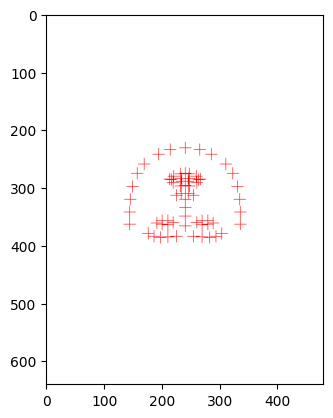

In [22]:
def display_projected_landmarks(landmarks: NDArray[np.float32], tag: str = '') -> None:
    # display projected points
    img = np.ones((int(CAMERA_FRAME_HEIGHT_PIXELS), int(CAMERA_FRAME_WIDTH_PIXELS), 3), dtype=np.uint8) * 255

    for landmark in landmarks:
        img = cv2.drawMarker(img, landmark.astype(np.int32), color=(255, 0, 0))

    plt.imshow(img)
    plt.title(f'{tag}')
    plt.show()

# display example landmark projection
display_projected_landmarks(projected_dlib_landmarks)




In [76]:
import random

def generate_landmark_projection(
        face_landmarks_3d_fcs: NDArray[np.float32],
        camera_frame_width_pixels: float = 480.0,
        camera_frame_height_pixels: float = 640.0,
        f: float = 500.00,
        t_x: float = 0.0,
        t_y: float = 0.0,
        t_z: float = 0.4,
        scale_x: float = 1.0,
        scale_y: float = 1.0,
        scale_z: float = 1.0,
        rot_x: float = 0.0,
        rot_y: float = 0.0,
        rot_z: float = 0.0) -> NDArray[np.float32]:
    """Generates a projection of 3D face landmarks onto a virtual camera frame for a given camera's f value and
    a range of x, y, z offsets, scale factors & rotation angles around X, Y, Z axes

    Args:
        face_landmarks_3d_fcs: _description_
        camera_frame_width_pixels: _description_. Defaults to 480.0.
        camera_frame_height_pixels: _description_. Defaults to 640.0.
        f: _description_. Defaults to 500.00.
        t_x: x translation between FCS and Camera Coordinate System (CCS). Defaults to 0.0.
        t_y: y translation between FCS and Camera Coordinate System (CCS). Defaults to 0.0.
        t_z: z translation between FCS and Camera Coordinate System (CCS). Defaults to 0.0.
        scale_x: scale factor along X axis. Defaults to 1.0.
        scale_y: scale factor along Y axis. Defaults to 1.0.
        scale_z: scale factor along Z axis. Defaults to 1.0.
        rot_x: rotation in radians around X axis between FCS and CCS. Defaults to 0.0.
        rot_y: rotation in radians around Y axis between FCS and CCS. Defaults to 0.0.
        rot_z: rotation in radians around Z axis between FCS and CCS. Defaults to 0.0.

    Returns:
        3D landmark projections on virtual camera frame in a form of NumPy array of shape (68, 2)
    """

    # create virtual camera matrix
    camera_matrix = np.array([
        [f, 0.0, camera_frame_width_pixels / 2],
        [0.0, f, camera_frame_height_pixels / 2],
        [0.0, 0.0, 1.0]
    ])

    assert camera_matrix.shape == (3, 3)

    # construct scaling matrix
    S = np.array([
        [scale_x, 0.0, 0.0],
        [0.0, scale_y, 0.0],
        [0.0, 0.0, scale_z],
    ])
    assert S.shape == (3, 3)

    # construct rotation matrices
    # according to: https://en.wikipedia.org/wiki/Rotation_matrix
    R_x = np.array([
        [1.0, 0.0, 0.0],
        [0.0, np.cos(rot_x), -np.sin(rot_x)],
        [0.0, np.sin(rot_x), np.cos(rot_x)],

    ])

    R_y = np.array([
        [np.cos(rot_y), 0.0, np.sin(rot_y)],
        [0.0, 1.0, 0.0],
        [-np.sin(rot_y), 0.0, np.cos(rot_y)],
    ])

    R_z = np.array([
        [np.cos(rot_z), -np.sin(rot_z), 0.0],
        [np.sin(rot_z), np.cos(rot_z), 0.0],
        [0.0, 0.0, 1.0],
    ])

    R_xyz = R_x @ R_y @ R_z
    assert R_xyz.shape == (3, 3)

    rvec, _ = cv2.Rodrigues(R_xyz)
    # print(rvec)

    # construct translation vector
    tvec = np.array([t_x, t_y, t_z])
    # print(tvec)

    # scale landmarks
    scaled_3d_landmarks = (S @ face_landmarks_3d_fcs.T).T
    assert scaled_3d_landmarks.shape == (68, 3)

    # NOTE: We assume zero distortions of virtual camera lens
    projected_landmarks, _ = cv2.projectPoints(scaled_3d_landmarks, rvec, tvec, camera_matrix, None)
    projected_landmarks = projected_landmarks.reshape(68, 2)

    return projected_landmarks


def generate_landmark_projections(
        face_landmarks_3d_fcs: NDArray[np.float32],
        camera_frame_width_pixels: float = 480.0,
        camera_frame_height_pixels: float = 640.0,
        f: float = 500.00,
        t_x_min: float = -0.1,
        t_x_max: float = 0.1,
        t_y_min: float = -0.3,
        t_y_max: float = 0.3,
        t_z_min: float = 0.3,
        t_z_max: float = 0.5,
        scale_x_min: float = 0.9,
        scale_x_max: float = 1.1,
        scale_y_min: float = 0.9,
        scale_y_max: float = 1.1,
        scale_z_min: float = 0.9,
        scale_z_max: float = 1.1,
        rot_x_min: float = 0.0,
        rot_x_max: float = 0.5,
        rot_y_min: float = 0.0,
        rot_y_max: float = 0.5,
        rot_z_min: float = 0.0,
        rot_z_max: float = 0.5,
        samples_count: int = 10) -> NDArray[np.float32]:
    """Generates a set of 3D face landmarks projections onto a virtual camera frame for a given camera's f value and
    a range of x, y, z offsets, scale factors & rotation angles around X, Y, Z axes

    Args:
        face_landmarks_3d_fcs: 3D locations of face landmarks in Face Coordinate System as NumPy array of shape (68, 3)
        camera_frame_width_pixels: width of camera frame in pixels. Defaults to 480.0.
        camera_frame_height_pixels: height of camera frame in pixels. Defaults to 640.0.
        f: normalized focal length. Defaults to 500.00.
        t_x_min: minimum x translation between FCS and Camera Coordinate System (CCS). Defaults to 0.1.
        t_x_max: maximum x translation between FCS and CCS. Defaults to 0.3.
        t_y_min: minimum y translation between FCS and CCS. Defaults to 0.1.
        t_y_max: maximum y translation between FCS and CCS. Defaults to 0.3.
        t_z_min: minimum z translation between FCS and CCS. Defaults to 0.3.
        t_z_max: maximum z translation between FCS and CCS. Defaults to 0.6.
        scale_x_min: minimum scale factor along X axis. Defaults to 0.9.
        scale_x_max: maximum scale factor along X axis. Defaults to 1.1.
        scale_y_min: minimum scale factor along Y axis. Defaults to 0.9.
        scale_y_max: maximum scale factor along Y axis. Defaults to 1.1.
        scale_z_min: minimum scale factor along Z axis. Defaults to 0.9.
        scale_z_max: maximum scale factor along Z axis. Defaults to 1.1.
        rot_x_min: minimum rotation in radians around X axis between FCS and CCS. Defaults to 0.0.
        rot_x_max: maximum rotation in radians around X axis between FCS and CCS. Defaults to 0.5.
        rot_y_min: minimum rotation in radians around Y axis between FCS and CCS. Defaults to 0.0.
        rot_y_max: maximum rotation in radians around Y axis between FCS and CCS. Defaults to 0.5.
        rot_z_min: minimum rotation in radians around Z axis between FCS and CCS. Defaults to 0.0.
        rot_z_max: maximum rotation in radians around Z axis between FCS and CCS. Defaults to 0.5.
        samples_count: how many projection samples to generate. Defaults to 10.

    Returns:
        set of 3D landmark projections on virtual camera frame in a form of NumPy array of shape (N, 68, 2)
    """

    projected_landmarks_batch = np.empty((samples_count, 68, 2))

    # generate a batch of data frames of landmark projections that would simulate a smooth movement of face
    # from one point on the screen to another

    # TODO: Find a good way to simulate face trajectory - currently this is just a very basic version
    # of the algorithm

    # randomly choose a scaling factor along X, Y & Z axis
    scale_x = random.uniform(scale_x_min, scale_x_max)
    scale_y = random.uniform(scale_y_min, scale_y_max)
    scale_z = random.uniform(scale_z_min, scale_z_max)

    iter = 0
    while True:

        # select initial head orientation and position
        init_t_x = random.uniform(t_x_min, t_x_max)
        init_t_y = random.uniform(t_y_min, t_y_max)
        init_t_z = random.uniform(t_z_min, t_z_max)

        init_rot_x = random.uniform(rot_x_min, rot_x_max)
        init_rot_y = random.uniform(rot_y_min, rot_y_max)
        init_rot_z = random.uniform(rot_z_min, rot_z_max)

        # select final head orientation and position
        final_t_x = random.uniform(t_x_min, t_x_max)
        final_t_y = random.uniform(t_y_min, t_y_max)
        final_t_z = random.uniform(t_z_min, t_z_max)

        final_rot_x = random.uniform(rot_x_min, rot_x_max)
        final_rot_y = random.uniform(rot_y_min, rot_y_max)
        final_rot_z = random.uniform(rot_z_min, rot_z_max)

        # generate initial and final landmark projection
        initial_projection = generate_landmark_projection(
            face_landmarks_3d_fcs,
            camera_frame_width_pixels,
            camera_frame_height_pixels,
            f,
            init_t_x, init_t_y, init_t_z,
            scale_x, scale_y, scale_z,
            init_rot_x, init_rot_y, init_rot_z
        )

        final_projection = generate_landmark_projection(
            face_landmarks_3d_fcs,
            camera_frame_width_pixels,
            camera_frame_height_pixels,
            f,
            final_t_x, final_t_y, final_t_z,
            scale_x, scale_y, scale_z,
            final_rot_x, final_rot_y, final_rot_z
        )

        # check if the initial & final landmarks fall into camera view
        invalid_initial_pose = not all([landmark[0] > 0 and landmark[0] < camera_frame_width_pixels and landmark[1] > 0 and landmark[1] < camera_frame_height_pixels for landmark in initial_projection])
        invalid_final_pose = not all([landmark[0] > 0 and landmark[0] < camera_frame_width_pixels and landmark[1] > 0 and landmark[1] < camera_frame_height_pixels for landmark in final_projection])

        # if initial or final projection lies outside of the camera view - look for a new initial or final location
        if not invalid_initial_pose and not invalid_final_pose:
            # we are good to go
            print(f'SUCCESS: Found good initial and final pose at iteration {iter}')
            break
        else:
            iter += 1
            print(f'WARNING: Invalid initial or final pose found in iteration {iter} - selecting a different pair...')

    # define a sequence of t_x, t_y, t_z, rot_x, rot_y & rot_z values along the movement trajectory
    t_xs = np.linspace(init_t_x, final_t_x, num=samples_count)
    t_ys = np.linspace(init_t_y, final_t_y, num=samples_count)
    t_zs = np.linspace(init_t_z, final_t_z, num=samples_count)

    rot_xs = np.linspace(init_rot_x, final_rot_x, num=samples_count)
    rot_ys = np.linspace(init_rot_y, final_rot_y, num=samples_count)
    rot_zs = np.linspace(init_rot_z, final_rot_z, num=samples_count)

    assert len(t_xs) == len(t_ys) == len(t_zs) == len(rot_xs) == len(rot_ys) == len(rot_zs) == samples_count

    print(f'Initial head pose: t: [{init_t_x:.03f},{init_t_y:.03f},{init_t_z:.03f}] rot: [{init_rot_x:.03f},{init_rot_y:.03f},{init_rot_z:.03f}]')
    print(f'Final head pose: t: [{final_t_x:.03f},{final_t_y:.03f},{final_t_z:.03f}] rot: [{final_rot_x:.03f},{final_rot_y:.03f},{final_rot_z:.03f}]')

    for i in range(samples_count):
        print(f'Sample {i}: t_x: {t_xs[i]:0.3f}, t_y: {t_ys[i]:.03f}, t_z: {t_zs[i]:.03f}, s_x: {scale_x:0.3f}, s_y: {scale_y:.03f}, s_z: {scale_z:.03f}, rot_x: {rot_xs[i]:.03f}, rot_y: {rot_ys[i]:.03f}, rot_z: {rot_zs[i]:.03f}')

        # project landmarks for a given set of parameters
        projected_landmarks = generate_landmark_projection(
            face_landmarks_3d_fcs,
            camera_frame_width_pixels,
            camera_frame_height_pixels,
            f,
            t_xs[i], t_ys[i], t_zs[i],
            scale_x, scale_y, scale_z,
            rot_xs[i], rot_ys[i], rot_zs[i])

        projected_landmarks_batch[i] = projected_landmarks

    return projected_landmarks_batch


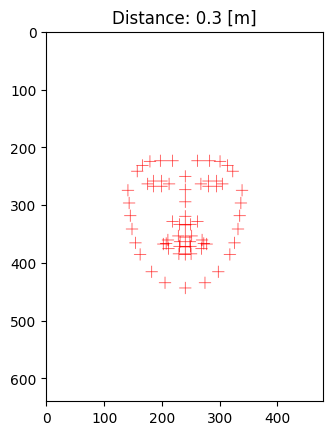

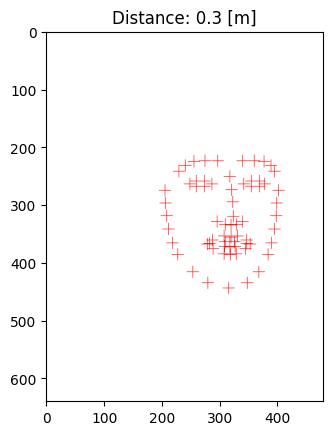

In [77]:
# display some examples of projections

# # distance 0.5 m
# t_z = 0.5
# projection_1 = generate_landmark_projection(DLIB_LANDMARKS_3D, t_z=t_z)
# display_projected_landmarks(projection_1, tag=f'Distance: {t_z} [m]')

# # distance 1.0 m
# t_z = 1.0
# projection_1 = generate_landmark_projection(DLIB_LANDMARKS_3D, t_z=t_z)
# display_projected_landmarks(projection_1, tag=f'Distance: {t_z} [m]')

# distance 0.3 m
t_z = 0.3
projection_1 = generate_landmark_projection(DLIB_LANDMARKS_3D, t_z=t_z)
display_projected_landmarks(projection_1, tag=f'Distance: {t_z} [m]')

# # distance 0.3 m, y translation -0.1 m
# t_y = -0.1
# t_z = 0.3
# projection_1 = generate_landmark_projection(DLIB_LANDMARKS_3D, t_y=t_y, t_z=t_z)
# display_projected_landmarks(projection_1, tag=f'Translate Y: {t_y}, Distance: {t_z} [m]')

# # distance 0.3 m, rotation around X axis (pitch)
# # NOTE: Positive rotation angle means turning the face downwards
# t_z = 0.3
# rot_x = 0.5
# projection_1 = generate_landmark_projection(DLIB_LANDMARKS_3D, t_z=t_z, rot_x=rot_x)
# display_projected_landmarks(projection_1, tag=f'Rotation X: {rot_x}, Distance: {t_z} [m]')

# # distance 0.3 m, rotation around X axis (pitch)
# # NOTE: Positive rotation angle means turning the face downwards
# t_z = 0.3
# rot_x = -0.5
# projection_1 = generate_landmark_projection(DLIB_LANDMARKS_3D, t_z=t_z, rot_x=rot_x)
# display_projected_landmarks(projection_1, tag=f'Rotation X: {rot_x}, Distance: {t_z} [m]')

# # distance 0.3 m, rotation around Y axis (yaw)
# # NOTE: Positive rotation angle means turning the face downwards
# t_z = 0.3
# rot_y = 0.5
# projection_1 = generate_landmark_projection(DLIB_LANDMARKS_3D, t_z=t_z, rot_y=rot_y)
# display_projected_landmarks(projection_1, tag=f'Rotation Y: {rot_y}, Distance: {t_z} [m]')

# # distance 0.3 m, rotation around X (pitch) & Y axis (pitch)
# # NOTE: Positive rotation angle means turning the face downwards
# t_z = 0.3
# rot_x = 0.5
# rot_y = 0.5
# projection_1 = generate_landmark_projection(DLIB_LANDMARKS_3D, t_z=t_z, rot_z=rot_z)
# display_projected_landmarks(projection_1, tag=f'Rotation Z: {rot_z}, Distance: {t_z} [m]')

# # distance 0.3 m, rotation around Z axis (roll)
# # NOTE: Positive rotation angle means turning the face downwards
# t_z = 0.3
# rot_z = 0.5
# projection_1 = generate_landmark_projection(DLIB_LANDMARKS_3D, t_z=t_z, rot_z=rot_z)
# display_projected_landmarks(projection_1, tag=f'Rotation Z: {rot_z}, Distance: {t_z} [m]')

# # distance 0.3 m, scale in X
# t_z = 0.3
# scale_x = 1.5
# projection_1 = generate_landmark_projection(DLIB_LANDMARKS_3D, t_z=t_z, scale_x=scale_x)
# display_projected_landmarks(projection_1, tag=f'Scale X: {scale_x}, Distance: {t_z} [m]')

# # f = 600
# t_z = 0.3
# f = 600.0
# projection_1 = generate_landmark_projection(DLIB_LANDMARKS_3D, t_z=t_z, f=f)
# display_projected_landmarks(projection_1, tag=f'F: {f}, Distance: {t_z} [m]')

# distance 0.3 m, rotation around Y axis (yaw)
# NOTE: Positive rotation angle means turning the face downwards
t_z = 0.3
t_x = 0.05
# rot_y = 0.5
projection_1 = generate_landmark_projection(DLIB_LANDMARKS_3D, t_x=t_x, t_z=t_z)
display_projected_landmarks(projection_1, tag=f'Distance: {t_z} [m]')



In [80]:
# initialize random generator with a fixed seed for deterministic results
# random.seed(101)

# generate dummy training data
landmark_projections_batch = generate_landmark_projections(DLIB_LANDMARKS_3D)
assert landmark_projections_batch.shape == (10, 68, 2)

SUCCESS: Found good initial and final pose at iteration 4
Initial head pose: t: [0.095,0.179,0.368] rot: [0.365,0.073,0.357]
Final head pose: t: [-0.017,-0.141,0.348] rot: [0.108,0.398,0.048]
Sample 0: t_x: 0.095, t_y: 0.179, t_z: 0.368, s_x: 1.079, s_y: 0.980, s_z: 0.911, rot_x: 0.365, rot_y: 0.073, rot_z: 0.357
Sample 1: t_x: 0.083, t_y: 0.143, t_z: 0.366, s_x: 1.079, s_y: 0.980, s_z: 0.911, rot_x: 0.337, rot_y: 0.109, rot_z: 0.323
Sample 2: t_x: 0.070, t_y: 0.108, t_z: 0.363, s_x: 1.079, s_y: 0.980, s_z: 0.911, rot_x: 0.308, rot_y: 0.146, rot_z: 0.288
Sample 3: t_x: 0.058, t_y: 0.072, t_z: 0.361, s_x: 1.079, s_y: 0.980, s_z: 0.911, rot_x: 0.279, rot_y: 0.182, rot_z: 0.254
Sample 4: t_x: 0.046, t_y: 0.037, t_z: 0.359, s_x: 1.079, s_y: 0.980, s_z: 0.911, rot_x: 0.251, rot_y: 0.218, rot_z: 0.220
Sample 5: t_x: 0.033, t_y: 0.001, t_z: 0.357, s_x: 1.079, s_y: 0.980, s_z: 0.911, rot_x: 0.222, rot_y: 0.254, rot_z: 0.185
Sample 6: t_x: 0.021, t_y: -0.034, t_z: 0.354, s_x: 1.079, s_y: 0.980,

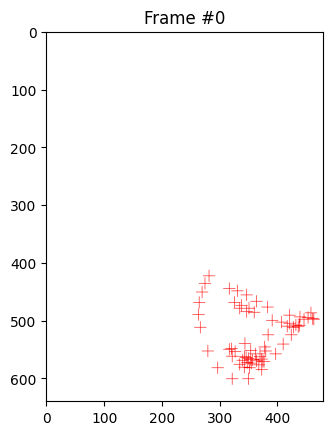

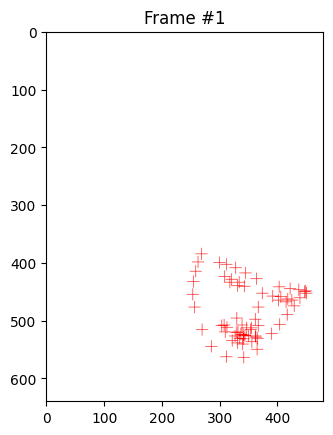

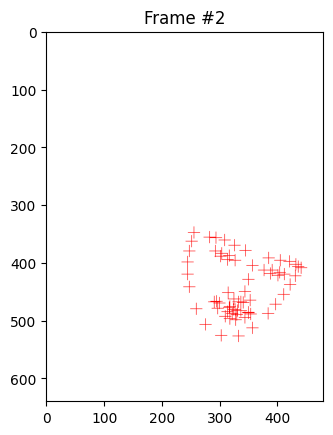

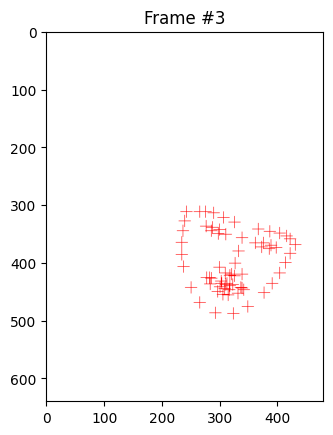

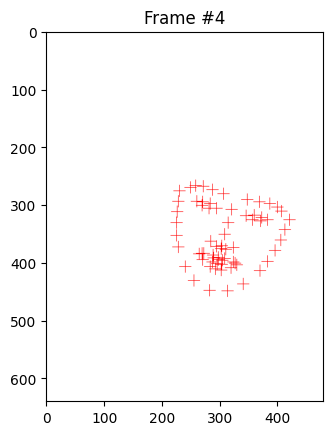

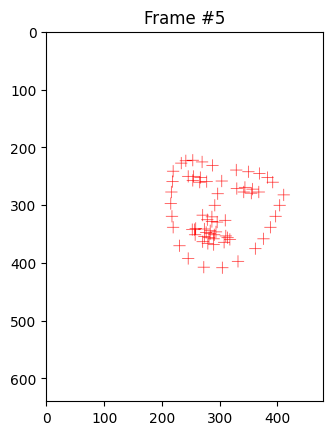

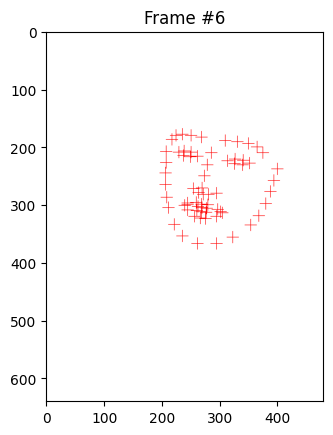

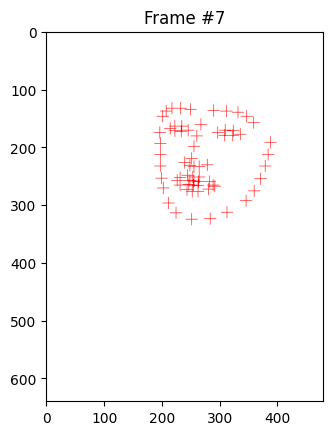

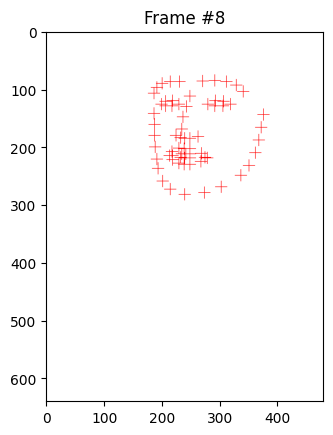

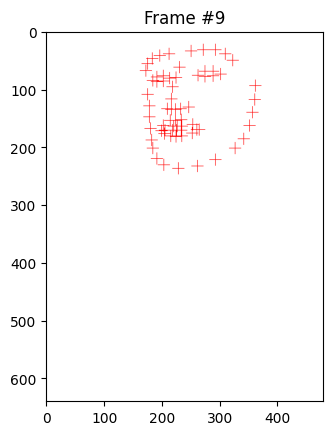

In [81]:
# display generated sequence of landmarks projections
for i, landmarks in enumerate(landmark_projections_batch):
    display_projected_landmarks(landmarks, tag=f'Frame #{i}')
